In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.1


In [2]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 32 * strategy.num_replicas_in_sync
# IMAGE_SIZE = [176, 208]
# EPOCHS = 10

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [176, 208]
batch_size = 32
epoch = 10

In [27]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alzheimer_s Dataset/train/',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alzheimer_s Dataset/train',
        validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2612 files belonging to 2 classes.
Using 2090 files for training.
Found 2612 files belonging to 2 classes.
Using 522 files for validation.


In [28]:
class_names = ['ModerateDementia', 'NonDementia']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

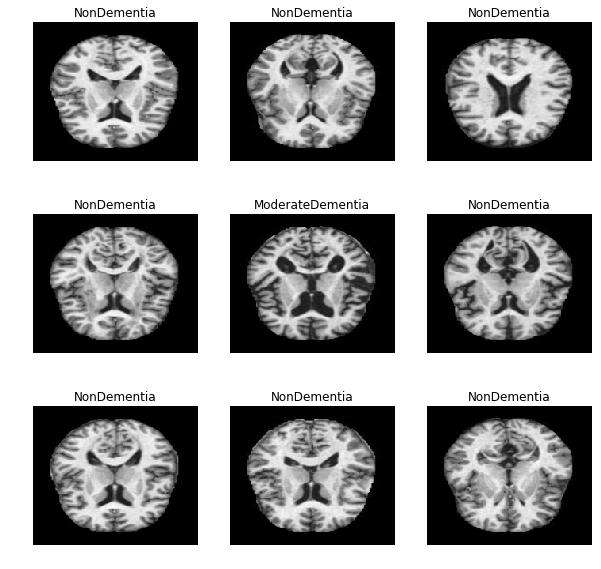

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

In [31]:

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [33]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


In [35]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [36]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [37]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [38]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [44]:
history = model.fit(
    train_data,
    validation_data=val_data,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10
66/66 [==============================] - 79s 1s/step - loss: 0.0601 - auc: 0.9976 - val_loss: 0.0504 - val_auc: 0.9994
Epoch 2/10
66/66 [==============================] - 76s 1s/step - loss: 0.0614 - auc: 0.9966 - val_loss: 0.0724 - val_auc: 0.9987
Epoch 3/10
66/66 [==============================] - 74s 1s/step - loss: 0.0497 - auc: 0.9986 - val_loss: 0.1336 - val_auc: 0.9844
Epoch 4/10
66/66 [==============================] - 76s 1s/step - loss: 0.0462 - auc: 0.9983 - val_loss: 0.2507 - val_auc: 0.9712
Epoch 5/10
66/66 [==============================] - 76s 1s/step - loss: 0.0860 - auc: 0.9919 - val_loss: 1.3604 - val_auc: 0.9751
Epoch 6/10
66/66 [==============================] - 74s 1s/step - loss: 0.0703 - auc: 0.9951 - val_loss: 0.0984 - val_auc: 0.9972
Epoch 7/10
66/66 [==============================] - 73s 1s/step - loss: 0.0505 - auc: 0.9976 - val_loss: 0.1265 - val_auc: 0.9891
Epoch 8/10
66/66 [==============================] - 72s 1s/step - loss: 0.0410 - auc: 0.99

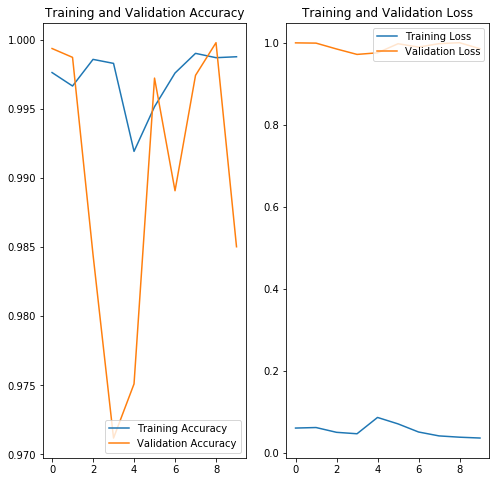

In [48]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_auc']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
w_standarization = model.fit(
    train_data,
    validation_data=val_data,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10
66/66 [==============================] - 71s 1s/step - loss: 0.8027 - auc: 0.6379 - val_loss: 0.4320 - val_auc: 0.9751
Epoch 2/10
66/66 [==============================] - 74s 1s/step - loss: 0.4531 - auc: 0.8755 - val_loss: 0.2669 - val_auc: 0.9751
Epoch 3/10
66/66 [==============================] - 71s 1s/step - loss: 0.2839 - auc: 0.9588 - val_loss: 0.1725 - val_auc: 0.9751
Epoch 4/10
66/66 [==============================] - 72s 1s/step - loss: 0.2091 - auc: 0.9742 - val_loss: 0.1292 - val_auc: 0.9751
Epoch 5/10
66/66 [==============================] - 77s 1s/step - loss: 0.1648 - auc: 0.9768 - val_loss: 0.1170 - val_auc: 0.9751
Epoch 6/10
66/66 [==============================] - 77s 1s/step - loss: 0.1445 - auc: 0.9785 - val_loss: 0.1239 - val_auc: 0.9751
Epoch 7/10
66/66 [==============================] - 82s 1s/step - loss: 0.1286 - auc: 0.9803 - val_loss: 0.1424 - val_auc: 0.9751
Epoch 8/10
66/66 [==============================] - 81s 1s/step - loss: 0.1258 - auc: 0.98

AttributeError: 'History' object has no attribute 'w_standarization'

In [67]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alzheimer_s Dataset/test/',
    image_size=image_size,
    batch_size=batch_size,
)
test_data = test_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 652 files belonging to 2 classes.


In [69]:
model.evaluate(test_data)

21/21 [==============================] - 6s 266ms/step - loss: 0.1569 - auc: 0.9816


[0.15693159401416779, 0.9815950989723206]

In [70]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [71]:
with strategy.scope():
    model = build_model_2()

    METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [62]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
num_classes = 5
def model_two():
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
])